In [1]:
import os
import sys
sys.path.insert(0, "../BlobOT")

import numpy as np
import matplotlib.pyplot as plt

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

import torch

import pickle

240210


In [2]:
from BlobOT import KE, NLE_pos, Model
from BlobOT import draw_straight_lines, EarlyStopping, endpoint_cost, allpoint_cost

def blobLoss(X, model):
  ke = KE(X, model.z, model.params)
  nle = NLE_pos(X, model.w, model.params)
  return ke + nle, ke, nle


def training_loop(model, optimizer, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=2, threshold=0,
                                                         factor=0.2)
  early_stopping = EarlyStopping(patience=5)

  losses=[]
  kes = []
  nles = []
  endpoint_costs = []
  allpoint_costs = []

  for i in range(n):
    preds = model()
    loss, ke, nle = blobLoss(preds, model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)

    losses.append(loss.detach())
    kes.append(ke.detach())
    nles.append(nle.detach())

    X = preds.detach().numpy()
    y = X[:,:,-1]

    c1 = endpoint_cost(y, T(z))
    endpoint_costs.append(c1)

    c2 = allpoint_cost(X, T(z))
    allpoint_costs.append(c2)

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return (np.array(losses), np.array(kes), np.array(nles), 
              np.array(endpoint_costs), np.array(allpoint_costs))

  return (np.array(losses), np.array(kes), np.array(nles), 
              np.array(endpoint_costs), np.array(allpoint_costs))



In [3]:
rng = np.random.RandomState(23)

d = 1
dt = 0.2
L = int(1/dt)

gd_steps = 3*int(1e5) 

N = 20

params = {'d': d, 'dt': dt, 'L': L, 'n': gd_steps, 'N': N}

params['delta'] = N**(-0.99)

epsilons = [0.1, 1] 

def T(x):
  return 0.5*x+2

z = np.sort(np.random.rand(N, d)) # uniform sampling from [0, 1]
w = T(np.sort(np.random.rand(N, d))) # uniform sampling from [2, 2.5]

z_tensor = torch.from_numpy(z)
w_tensor = torch.from_numpy(w)

y0 = np.ones((N, d))*(T(0) + T(1))/2 # initialize at 2.25
X0 = draw_straight_lines(z, y0, params['L']+1)

res = {'z': z, 'w': w, 'params': params, 'epsilons': epsilons}

for j, eps in enumerate(epsilons):
  params['eps'] = eps
  params['lr'] = max(eps/1e3, 1e-5)

  print(params)

  # run gradient descent
  m = Model(torch.from_numpy(X0), w_tensor, z_tensor, params)
  opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
  losses, kes, nles, endpoint_costs, allpoint_costs = training_loop(m, opt, n=params['n'])
  
  X = m.X.data.detach().numpy()

  print('endpoint cost:', endpoint_costs[-1],
        'allpoint cost:', allpoint_costs[-1])
  
  # save results
  res[str(eps)] = (X.copy(), losses, kes, nles, endpoint_costs, allpoint_costs)

with open(os.path.join('../output/', f'diff_eps_{date}.pkl'), 'wb') as f:
    pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)


{'d': 1, 'dt': 0.2, 'L': 5, 'n': 300000, 'N': 20, 'delta': 0.05152052789556263, 'eps': 0.1, 'lr': 0.0001}
endpoint cost: 0.036343174051858426 allpoint cost: 0.02490620548423908
{'d': 1, 'dt': 0.2, 'L': 5, 'n': 300000, 'N': 20, 'delta': 0.05152052789556263, 'eps': 1, 'lr': 0.001}
endpoint cost: 0.7681282975885092 allpoint cost: 0.525901281123767


# Plotting

In [4]:
with open(os.path.join('../output', f'diff_eps_{date}.pkl'), 'rb') as f:
    res = pickle.load(f)

print(res.keys())
print(len(res['1']))

epsilons = res['epsilons']
z, w, params = res['z'], res['w'], res['params']


dict_keys(['z', 'w', 'params', 'epsilons', '0.1', '1'])
6


In [5]:
def plot_one_run(res, params, j):
  fig, ax = plt.subplots(2, 2, figsize=(5*2, 5*2))
  (X, losses, kes, nles, endpoint_costs, allpoint_costs) = res
  y = X[:,:,-1]

  # plot particle trajectory
  if X.shape[-1] <= params['L']:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)
  
  t = params['dt']*np.arange(params['L']+1)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0, 0].plot(traj[:, 0], t,  color=[.5, .5, 1])
  
  ax[0, 0].scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
  ax[0, 0].scatter(w[:, 0], 1 + np.zeros_like(w[:, 0]), marker='x', c='r', label='Target')
  ax[0, 0].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')
    
  # plot error wrt OT map
  steps = range(1, int(len(kes))+1)

  ax[0, 1].plot(steps, endpoint_costs, linewidth=3, label=r'At $t=1$')
  ax[0, 1].plot(steps, allpoint_costs, linestyle='--', linewidth=3, label = 'At all time points')
  ax[0, 1].set_xscale('log')
  ax[0, 1].set_yscale('log')

  # plot loss function values - raw
  l1 = ax[1, 0].plot(steps, kes, linewidth=3, label = r'KE', color='tab:blue')
  l2 = ax[1, 0].plot(steps, nles, linestyle='--', linewidth=3, label='NLE', color='tab:orange')
  l3 = ax[1, 0].plot(steps, losses, linestyle='-.', linewidth=3, label=r'Total loss', color='tab:green')
  ax[1, 0].set_xscale('log')
  ax[1, 0].set_yscale('log')

  lns10 = l1+l2+l3

  # plot loss function values - double y axis
  ax2 = ax[1, 1].twinx() 
  
  l1 = ax[1, 1].plot(steps, kes, linewidth=3, label = r'KE (left axis)', color='tab:blue')
  l2 = ax2.plot(steps, nles, linestyle='--', linewidth=3, label='NLE (right axis)', color='tab:orange') 
  ax[1, 1].set_xscale('log')
 
  lns11 = l1+l2

  # labeling things in the plot
  kwarg = dict(fontsize=22)
  leg_kwarg = dict(fontsize=16, markerscale=2)
  tick_kwarg = dict(labelsize=16)
  x_kwarg = dict(fontsize=16)
  
  ax[0, 0].xaxis.set_tick_params(**tick_kwarg)
  ax[0, 1].xaxis.set_tick_params(**tick_kwarg)
  ax[1, 0].xaxis.set_tick_params(**tick_kwarg)
  ax[1, 1].xaxis.set_tick_params(**tick_kwarg)

  ax[0, 0].yaxis.set_tick_params(**tick_kwarg)
  ax[0, 1].yaxis.set_tick_params(**tick_kwarg)
  ax[1, 0].yaxis.set_tick_params(**tick_kwarg)
  ax[1, 1].yaxis.set_tick_params(labelcolor='tab:blue', **tick_kwarg)
  ax2.yaxis.set_tick_params(labelcolor='tab:orange', **tick_kwarg)
     
  ax[0, 0].set_yticks([0, 1], ['$t$=0', '$t$=1'])
  ax[0, 1].set_yticks([0.01, 0.05, 0.1, 0.5, 1], [0.01, 0.05, 0.1, 0.5, 1])
  ax[1, 1].set_yticks([2.25, 2.5, 2.75, 3, 3.25], [2.25, 2.5, 2.75, 3, 3.25])
  
  if j == 0:
    ax2.set_yticks([0, 20, 40, 60], [0, 20, 40, 60])
  elif j==1:
    ax2.set_yticks([0, 0.05, 0.1, 0.15], [0, 0.05, 0.1, 0.15])

  ax[1, 0].set_ylim([2*1e-4, 1e2])

  ax[0, 0].set_title(r'Particle trajectory', **kwarg)
  ax[0, 1].set_title('Error from OT map', **kwarg)
  ax[1, 0].set_title('Loss function', **kwarg)
  ax[1, 1].set_title('Loss function (w/o total loss)', **kwarg)

  ax[0, 0].legend(**leg_kwarg)
  ax[0, 1].legend(**leg_kwarg)

  labs = [l.get_label() for l in lns10]

  if j == 0:
    ax[1, 0].legend(lns10, labs, loc=7, **leg_kwarg)  
  else:
    ax[1, 0].legend(lns10, labs, loc=4, **leg_kwarg) 

  labs = [l.get_label() for l in lns11]
  if j == 0:
    ax[1, 1].legend(lns11, labs, loc=7, **leg_kwarg)  
  else:
    ax[1, 1].legend(lns11, labs, loc=2, **leg_kwarg)  

  ax[0, 0].set_xlabel(r'1 dimensional $x(t)$', **x_kwarg)
  ax[0, 1].set_xlabel('Gradient descent steps', **x_kwarg)
  ax[1, 0].set_xlabel('Gradient descent steps', **x_kwarg)
  ax[1, 1].set_xlabel('Gradient descent steps', **x_kwarg)
  
  plt.tight_layout(pad=0)
  eps = params['eps']
  plt.savefig(os.path.join('../output', f'diff_eps_{date}_{eps}.pdf'), dpi=300)
  plt.show()
  plt.close()

  


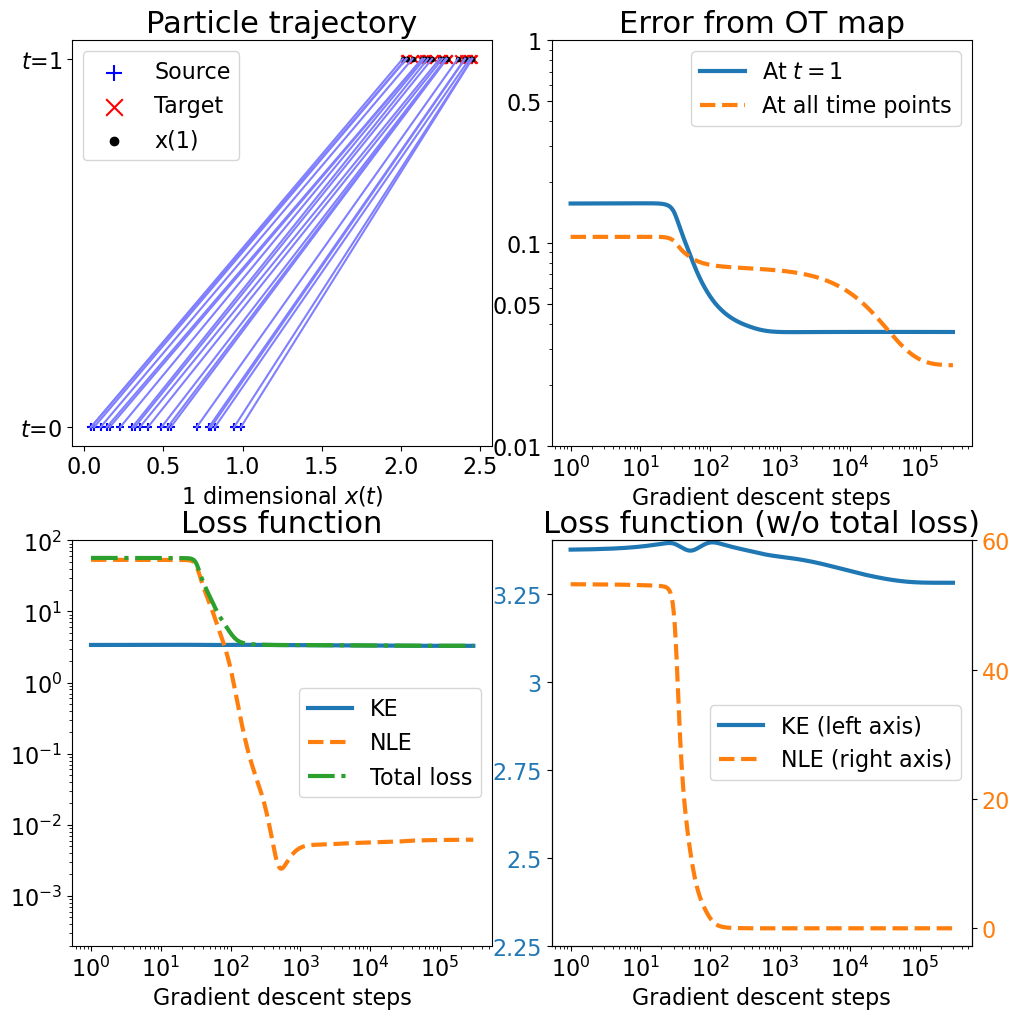

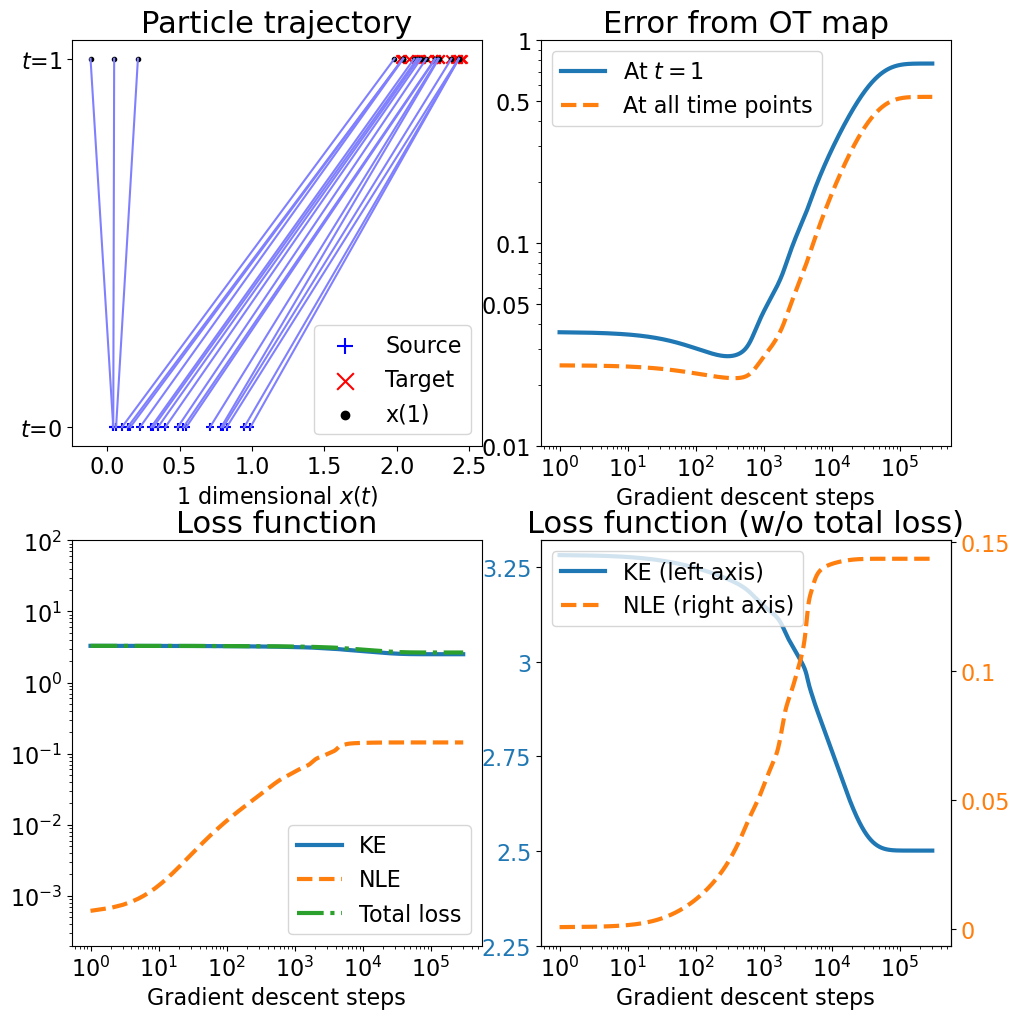

In [6]:
for j, eps in enumerate(epsilons):
  params['eps'] = eps
  plot_one_run(res[str(eps)], params, j)



In [7]:
# def plot_one_run(res, params, ax, shifted=True):
#   (X, losses, kes, nles, endpoint_costs, allpoint_costs) = res
#   y = X[:,:,-1]

#   # plot particle trajectory
#   if X.shape[-1] <= params['L']:
#     X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)
  
#   t = params['dt']*np.arange(params['L']+1)

#   for p in range(X.shape[0]):
#     traj = X[p].T
#     ax[0].plot(traj[:, 0], t,  color=[.5, .5, 1])
  
#   ax[0].scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
#   ax[0].scatter(w[:, 0], 1 + np.zeros_like(w[:, 0]), marker='x', c='r', label='Target')
#   ax[0].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')
  
#   # plot loss function values
#   steps = range(1, int(len(kes))+1)
  
#   if shifted:
#     ax2 = ax[1].twinx() # double y axis
    
#     l1 = ax[1].plot(steps, kes, linewidth=3, label = r'KE (left axis)', color='tab:blue')
#     l2 = ax2.plot(steps, nles, linestyle='--', linewidth=3, label='NLE (right axis)', color='tab:orange') 
    
#     lns = l1+l2
#   else: 
#     l1 = ax[1].plot(steps, kes, linewidth=3, label = r'KE', color='tab:blue')
#     l2 = ax[1].plot(steps, nles, linestyle='--', linewidth=3, label='NLE', color='tab:orange')
#     l3 = ax[1].plot(steps, losses, linestyle='-.', linewidth=3, label=r'Total loss', color='tab:green')

#     lns = l1+l2+l3
#     ax[1].set_yscale('log')

#   ax[1].set_xscale('log')
  
#   # plot error wrt OT map
#   ax[2].plot(steps, endpoint_costs, linewidth=3, label=r'At $t=1$')
#   ax[2].plot(steps, allpoint_costs, linestyle='--', linewidth=3, label = 'At all time points')
#   ax[2].set_xscale('log')
#   ax[2].set_yscale('log')
  
#   # labeling things in the plot
#   kwarg = dict(fontsize=24)
#   leg_kwarg = dict(fontsize=16, markerscale=2)
#   tick_kwarg = dict(labelsize=16)
  
#   ax[0].yaxis.set_tick_params(**tick_kwarg)
#   ax[2].yaxis.set_tick_params(**tick_kwarg)
  
#   if shifted:
#     ax[1].yaxis.set_tick_params(labelcolor='tab:blue', **tick_kwarg)
#     ax2.yaxis.set_tick_params(labelcolor='tab:orange', **tick_kwarg)
#   else:
#     ax[1].yaxis.set_tick_params(**tick_kwarg)
   
#   ax[0].set_yticks([0, 1], ['$t$=0', '$t$=1'])
#   ax[2].set_yticks([0.1, 0.5, 1], [0.1, 0.5, 1])
  
#   ax[0].set_ylabel(r'$\epsilon=$'+str(params['eps']), **kwarg)

#   if j == 0:
#     ax[0].set_title(r'Particle trajectory', **kwarg)
#     ax[1].set_title('Objective function value', **kwarg)
#     ax[2].set_title('Error from OT map', **kwarg)
    
#     labs = [l.get_label() for l in lns]
#     ax[2].legend(**leg_kwarg)

#     if shifted:
#       ax2.set_yticks([0, 20, 40, 60], [0, 20, 40, 60])
#       ax[1].legend(lns, labs, loc=7, **leg_kwarg)  
#     else:
#       ax[1].legend(lns, labs, loc=3, **leg_kwarg)  
  
#   if j == len(epsilons)-1:
#     ax[0].legend(**leg_kwarg)
    
#     ax[0].set_xlabel(r'1 dimensional $x(t)$', **kwarg)
#     ax[1].set_xlabel('Gradient descent steps', **kwarg)
#     ax[2].set_xlabel('Gradient descent steps', **kwarg)

#     ax[0].xaxis.set_tick_params(**tick_kwarg)
#     ax[1].xaxis.set_tick_params(**tick_kwarg)
#     ax[2].xaxis.set_tick_params(**tick_kwarg)

#     if shifted:
#       ax2.set_yticks([0, 0.05, 0.1, 0.15], [0, 0.05, 0.1, 0.15])
#   else:

#     ax[0].set_xticks([])
#     ax[1].set_xticks([])
#     ax[2].set_xticks([])

#     ax[0].set_xticks([], minor=True)
#     ax[1].set_xticks([], minor=True)
#     ax[2].set_xticks([], minor=True)
  


In [8]:
# for shifted in [True, False]:
#   fig, ax = plt.subplots(len(epsilons), 3, figsize=(5*3, 4*len(epsilons)))

#   for j, eps in enumerate(epsilons):
#     params['eps'] = eps
#     plot_one_run(res[str(eps)], params, ax[j,:], shifted=shifted)

#   # share x, y axis
#   if shifted:
#     for c in [1, 2]:
#       ylims = np.array([a.get_ylim() for a in ax[:, c]])
#       xlims = np.array([a.get_xlim() for a in ax[:, c]])

#       for cell in ax[:, c]:
#         cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
#         cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))
#   else:
#     ylims = np.array([a.get_ylim() for a in ax[:, 2]])
#     xlims = np.array([a.get_xlim() for a in ax[:, 2]])

#     for cell in ax[:, 2]:
#       cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
#       cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))
    
#     ylims = np.array([a.get_ylim() for a in ax[:, 1]])
#     xlims = np.array([a.get_xlim() for a in ax[:, 1]])

#     for cell in ax[:, 1]:
#       cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]+100))
#       cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]+100))

#   plt.tight_layout(pad=0)
#   if shifted:
#     plt.savefig(os.path.join(DRIVE_PATH, f'diff_eps_{date}_shifted.pdf'), dpi=300)
#   else:
#     plt.savefig(os.path.join(DRIVE_PATH, f'diff_eps_{date}.pdf'), dpi=300)
#   plt.close()